# <span style='font-family:"Times New Roman"'> <span styel=''> **INDETERMINATE INVESTIGATION**

## <span style='font-family:"Times New Roman"'> <span styel=''> *Emile Cohen* 
*March 2020*

**Goal:** In this notebook, we want to understand if we could consider the INDETERMINATE CN status in our study. Indeed, they represent a not negligible proportion of tp53 positive patients. For that we use the arm_level table and the expected number of copies  of tp53 mutations. 
    
The Notebook is divided in X parts:


**NB1:** In each part, you must run the cells from the begining in order to initialize the variables

**NB2:** All functions used for the plots are located in utils/custom_tools.py

---

In [32]:
%run -i '../../utils/setup_environment.ipy'
from utils.analysis_tools import *

import warnings, math

warnings.filterwarnings('ignore')
import ptitprince as pt
import IPython.display
from itertools import cycle, islice
from lifelines import KaplanMeierFitter

data_path = '../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

---

In [3]:
# Loading the master
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')
# Loading arm_level
arm_level = pd.read_csv(data_path + 'impact-facets-tp53/raw/default_qc_pass.arm_level.txt', sep='\t')

In [4]:
indeterminate_samples = list(master[master['cn_state'] == 'INDETERMINATE'][master['tp53_count'].isin([1,2,3,4,5])]['Tumor_Id'])
arm_level['Tumor_Id'] = arm_level['sample'].str[:17]

We print the CN state that correponds to the 17p arm in arm level for the samples that are INDETERMINATE in gene_level

In [5]:
# Distribution of cn_state from arm_level on 17p for INDETERMINATE in gene_level
arm_level_indeterminates = arm_level[arm_level['arm'] == '17p'][arm_level['Tumor_Id'].isin(indeterminate_samples)]
get_groupby(arm_level_indeterminates, 'cn_state', 'count').sort_values(by=['count'], ascending=False)

,count
cn_state,
LOSS BEFORE,272
DIPLOID,156
LOSS AFTER,136
HETLOSS,108
CNLOH BEFORE & LOSS,101
GAIN,73
LOSS BEFORE & AFTER,66
CNLOH,54
TETRAPLOID,46


---
Now, we want to see the distribtution of expected copies of tp53 mutations for these samples to see if it is matching the patterns we know or not.

In [6]:
arm_level_indeterminates

,sample,arm,tcn,lcn,cn_length,arm_length,frac_of_arm,cn_state,Tumor_Id
547,P-0018241-T01-IM6_P-0018241-N01-IM6,17p,3,1,22148456,22148456,1.0,LOSS AFTER,P-0018241-T01-IM6
2808,P-0034797-T02-IM6_P-0034797-N01-IM6,17p,2,0,22148367,22148367,1.0,LOSS BEFORE,P-0034797-T02-IM6
3930,P-0009818-T01-IM5_P-0009818-N01-IM5,17p,3,1,22148406,22148406,1.0,LOSS AFTER,P-0009818-T01-IM5
7740,P-0030962-T01-IM6_P-0030962-N01-IM6,17p,2,0,22148337,22148337,1.0,LOSS BEFORE,P-0030962-T01-IM6
9310,P-0013913-T01-IM5_P-0013913-N01-IM5,17p,2,1,22148488,22148488,1.0,DIPLOID,P-0013913-T01-IM5
...,...,...,...,...,...,...,...,...,...
1050844,P-0050566-T01-IM6_P-0050566-N01-IM6,17p,3,0,18694261,18694261,1.0,CNLOH & GAIN,P-0050566-T01-IM6
1052136,P-0050621-T01-IM6_P-0050621-N01-IM6,17p,5,2,4046456,4046456,1.0,GAIN,P-0050621-T01-IM6
1052699,P-0050666-T01-IM6_P-0050666-N01-IM6,17p,2,0,22148506,22148506,1.0,LOSS BEFORE,P-0050666-T01-IM6
1054027,P-0050661-T01-IM6_P-0050661-N01-IM6,17p,1,0,22148337,22148337,1.0,HETLOSS,P-0050661-T01-IM6


In [11]:
master_indeterminates = master[master['cn_state'] == 'INDETERMINATE'][master['tp53_count'].isin([1,2,3,4,5])]
master_indeterminates = master_indeterminates[['Tumor_Id','tcn', 'lcn','exp_nb_1','exp_nb_2','exp_nb_3','exp_nb_4','exp_nb_5']]

In [29]:
# We merge arm_level and master
final = pd.merge(arm_level_indeterminates, master_indeterminates, left_on=['Tumor_Id'], right_on=['Tumor_Id'])

# We filter out the tcn that are too big, and we select the subgroups
final = final[final['tcn_y'] <=4][final['cn_state'].isin(['DIPLOID', 'LOSS BEFORE', 'LOSS AFTER'])]

Text(0.5, 1.0, 'INDETERMINATE distribtuion of number of copies')

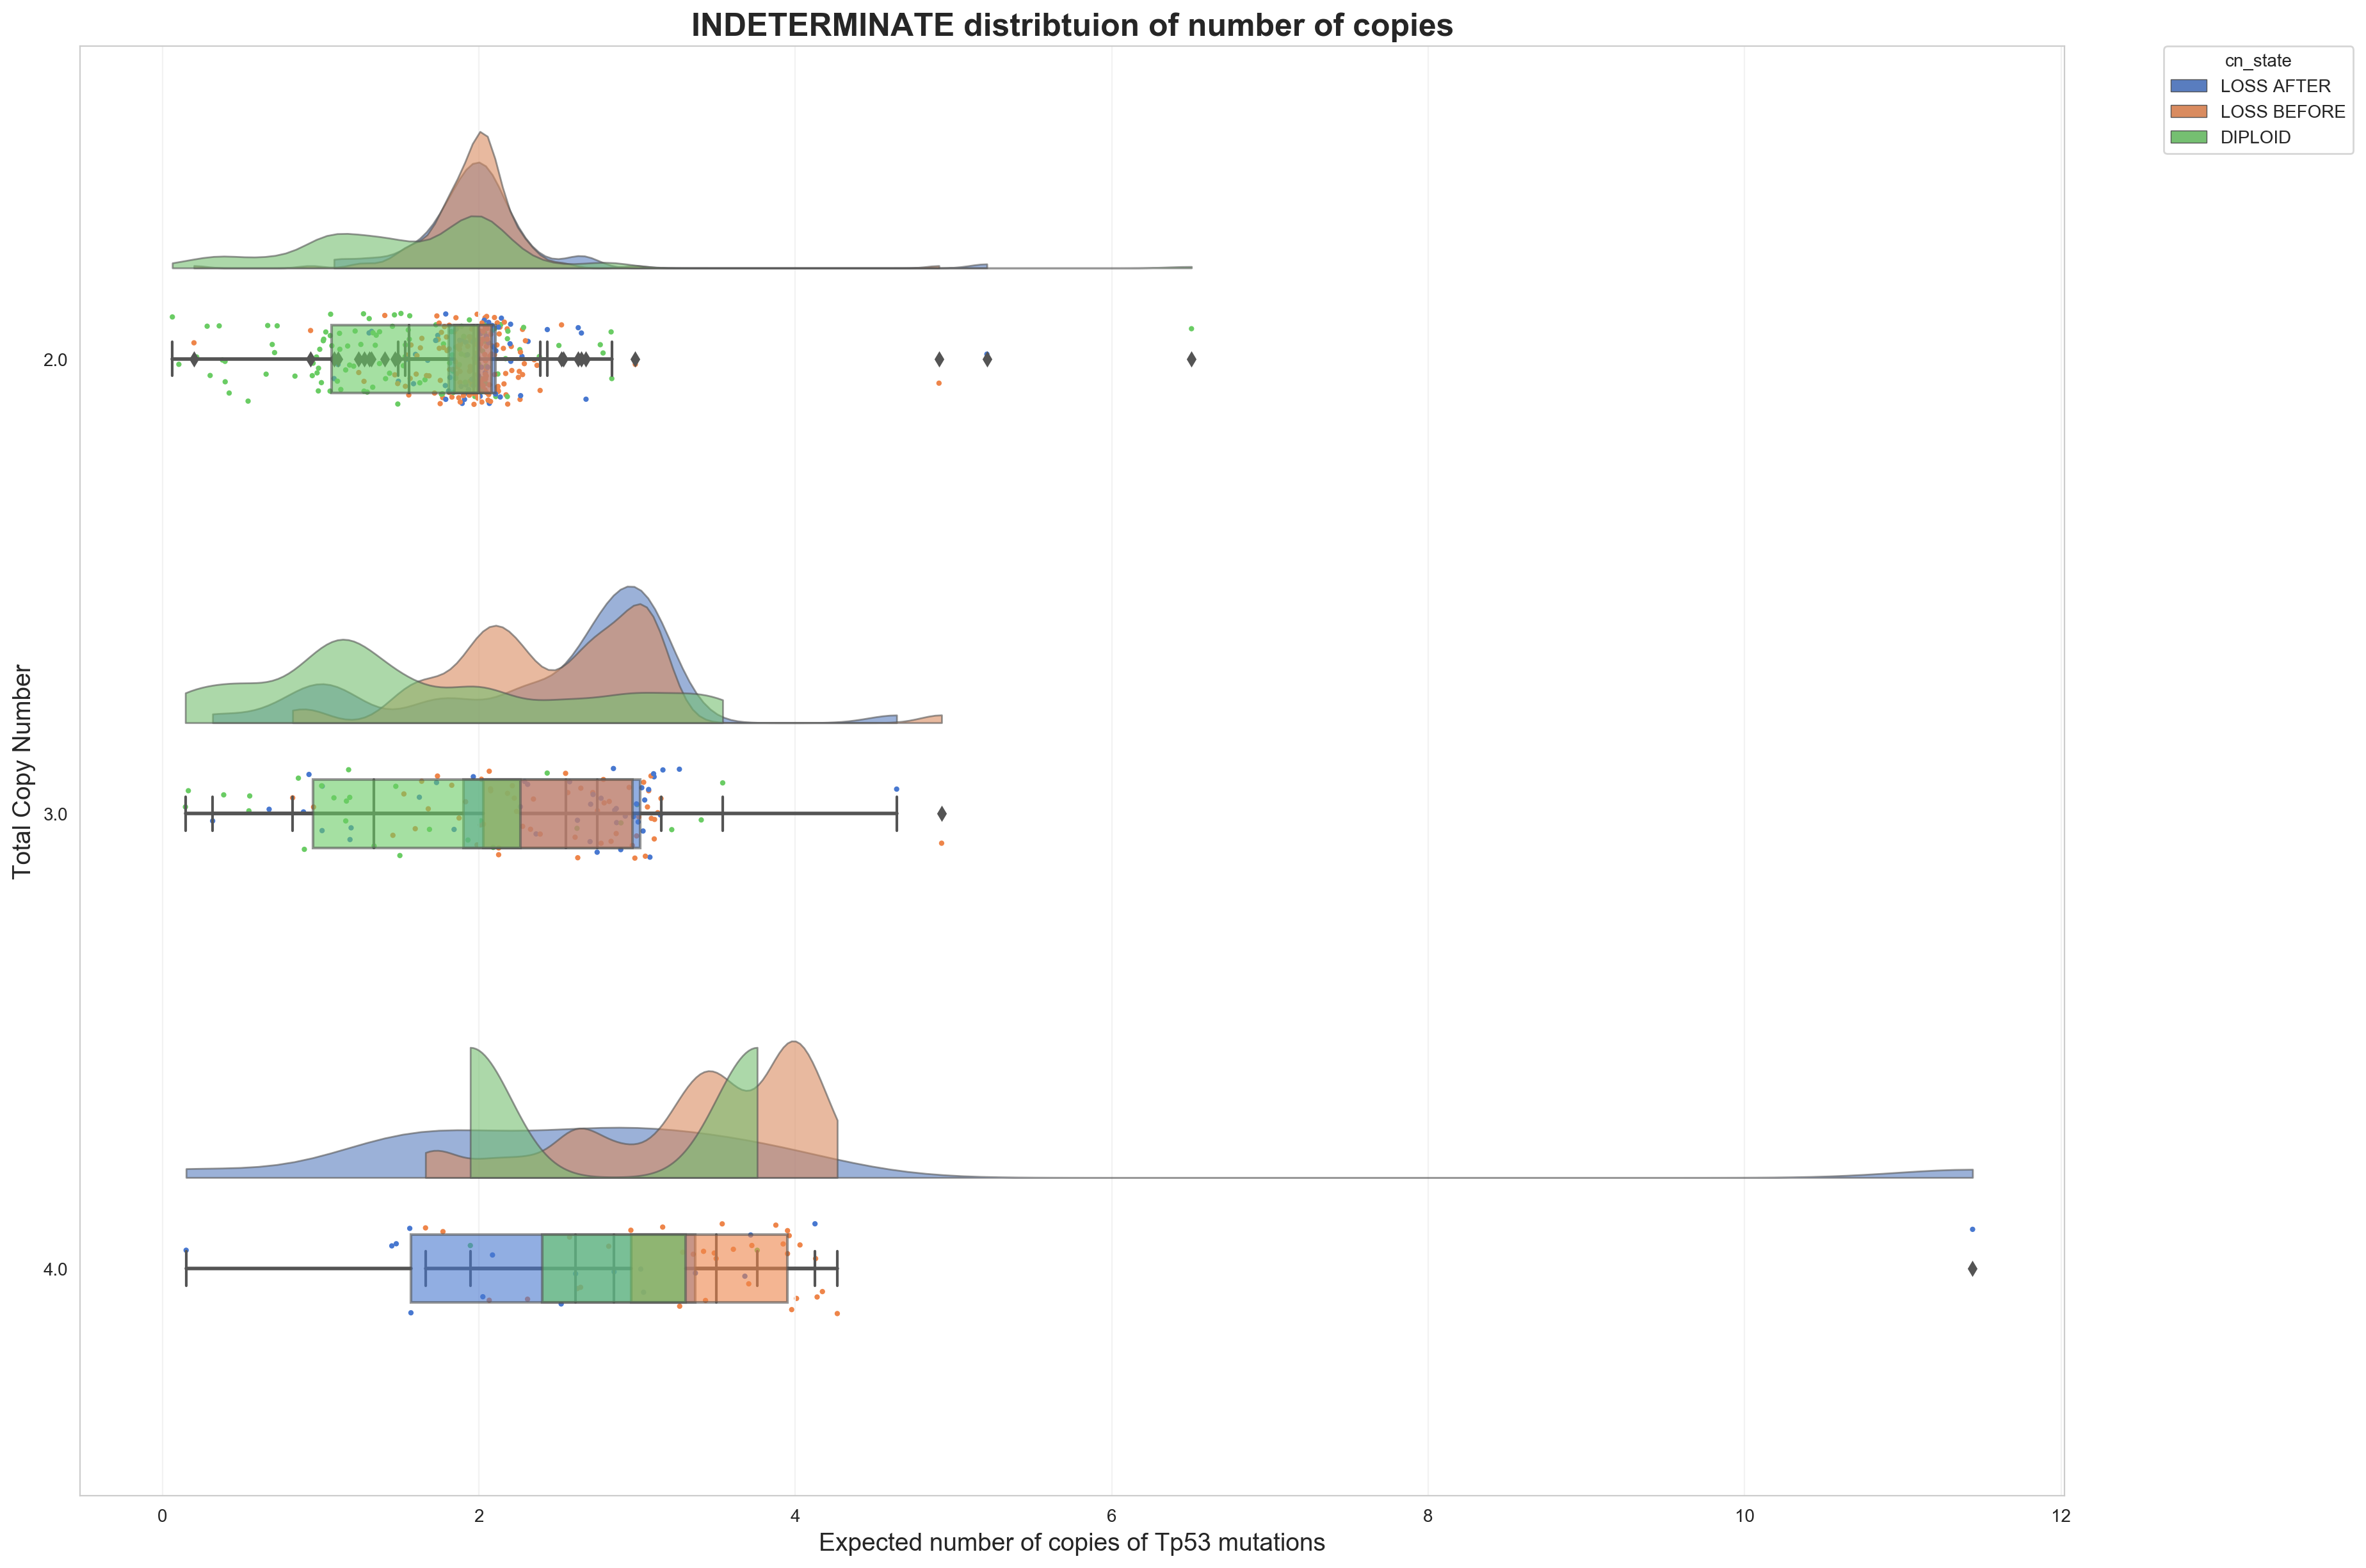

In [36]:
dx="tcn_y"; dy="exp_nb_1"; ort="h"; pal = "muted"; sigma = .2; dhue = "cn_state"

f, ax = plt.subplots(figsize=(20, 15))

ax=pt.RainCloud(x = dx, y = dy, data = final, palette = pal, bw = sigma, hue=dhue,
                 width_viol = .6, ax = ax, orient = ort, alpha=.6, mv=.2)
ax.set_ylabel('Total Copy Number', fontsize=14)
ax.set_xlabel('Expected number of copies of Tp53 mutations', fontsize=14)
ax.set_title('INDETERMINATE distribtuion of number of copies', weight = 'bold', fontsize=18)